In [1]:
# Run preprocessing script to make dataframe objects available.

%run PreProcessing.ipynb

Current Progress: 100.0 %
The old training dataframe shape: (2932, 44)
Total number of outliers identified is:  147
The new training dataframe shape: (2785, 44)


In [2]:
# Import required libraries.

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.evaluate import bias_variance_decomp
from sklearn.pipeline import Pipeline

In [3]:
# Hypertuning model to find best parameters.
# Print the best qualitative parameters to use within the model.

param_grid_1 = {'fit_intercept': [True, False],
                'positive': [True, False]}
   
grid_lin = GridSearchCV(LinearRegression(), param_grid_1, refit = True, verbose = 3, n_jobs=-1, cv = 2)

grid_lin.fit(MinMaxScaler().fit_transform(X_train), y_train) 
 
print(f'Best Parameters = {grid_lin.best_params_}')

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Best Parameters = {'fit_intercept': False, 'positive': False}


In [4]:
# Fit semi-hypertuned model and print score.

lin = Pipeline([('lin', LinearRegression(fit_intercept=False, positive=False))])

lin.fit(X_train, y_train)
print(f'Accuracy = {lin.score(X_test, y_test):.2f}')

Accuracy = 0.83


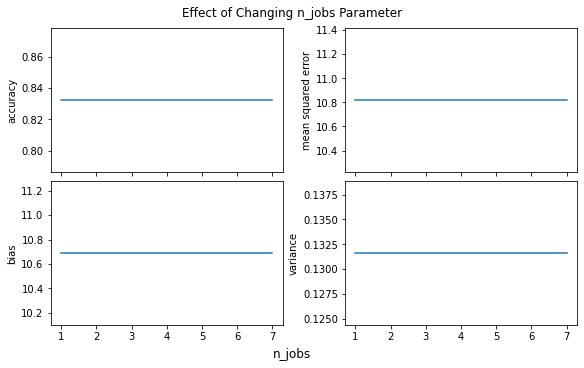

In [5]:
# Optimisation of n_estimators parameter.

hypertune_eval('n_jobs', 1, 8, 1, lin)

In [7]:
# Set parameter to optimum.
lin[-1].set_params(n_jobs = 1)
lin.fit(X_train, y_train)
print(f'Accuracy = {lin.score(X_test, y_test):.2f}')
lin_pred = lin.predict(X_test)

mse_decomp, bias_decomp, var_decomp = bias_variance_decomp(lin, X_train.values, y_train.values, X_test.values, y_test.values, loss= 'mse', num_rounds = 30, random_seed = 1)

print(f'Mean Error = {mse_decomp**0.5:.2f}')
print(f'Bias = {bias_decomp:.2f}')
print(f'Variance = {var_decomp:.2f}')

Accuracy = 0.83
Mean Error = 3.29
Bias = 10.70
Variance = 0.15


In [8]:
# Join 'X' and 'y' test df together along with predictions to make visualisations easier.
# Please note... only the test data.

y_test_df = y_test.to_frame()
y_test_df = y_test_df.rename(columns = {0:'mean_diameter'}).reset_index(drop=True)

pred_df = pd.DataFrame(lin_pred, columns = ['predicted_mean_diameter']).reset_index(drop=True)

X_test_df = pd.DataFrame(X_test, columns = list(X_test)).reset_index(drop = True)

test_df = X_test_df.copy()
test_df['predicted_mean_diameter'] = pd.Series(pred_df['predicted_mean_diameter'])
test_df['mean_diameter'] = pd.Series(y_test_df['mean_diameter'])

test_df = trns.inverse_transform(test_df)
test_df.head()

,pp2m2,heat_units,solar_radiation,organic_matter,predicted_mean_diameter,mean_diameter,method,variety,inputs,protection
0,35,858,555803,2.5,14.500900,10.829714,Bare Roots,Chiefton,Conventional,None
1,37,1627,1329865,18.3,14.500020,15.167568,Drilled,Batter,Conventional,Barley
2,38,2495,1604512,2.8,28.280832,31.715789,Drilled,Chiefton,Conventional,None
3,46,1236,1336335,30.1,13.026468,12.820000,Drilled,Krypton,Conventional,Barley
4,33,1102,668715,2.6,15.636176,19.543030,Plant Tape,Chiefton,Conventional,None


In [9]:
test_df.shape

(734, 10)

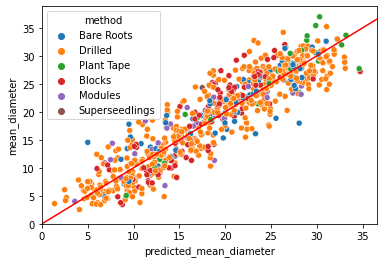

In [10]:
# Scatterplot to show how predicted mean compares to actual mean.
# Set hue to see if any indicator variables have a bias.

sns.scatterplot(y = 'mean_diameter', x = 'predicted_mean_diameter', data = test_df, hue='method')
plt.axline([0, 0], [1, 1], color = 'r')
plt.ylim(0)
plt.xlim(0)
plt.show()